https://www.kaggle.com/competitions/foursquare-location-matching/data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from geopandas import GeoDataFrame
import geopandas as gpd

from sklearn.decomposition import PCA

# Read data from Kaggel data sets

`train.csv` 
`pairs.csv`


In [2]:
df_train  = pd.read_csv("./data-foursquare-location-matching/train.csv")
df_pairs  = pd.read_csv("./data-foursquare-location-matching/pairs.csv")
# df_test   = pd.read_csv("./data-foursquare-location-matching/test.csv")
# df_sample = pd.read_csv("./data-foursquare-location-matching/sample_submission.csv")

# Exploring `train.csv`

## Basic information

In [3]:
df = df_train # working data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138812 entries, 0 to 1138811
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   id                 1138812 non-null  object 
 1   name               1138811 non-null  object 
 2   latitude           1138812 non-null  float64
 3   longitude          1138812 non-null  float64
 4   address            742191 non-null   object 
 5   city               839623 non-null   object 
 6   state              718226 non-null   object 
 7   zip                543386 non-null   object 
 8   country            1138801 non-null  object 
 9   url                267724 non-null   object 
 10  phone              342855 non-null   object 
 11  categories         1040505 non-null  object 
 12  point_of_interest  1138812 non-null  object 
dtypes: float64(2), object(11)
memory usage: 112.9+ MB


In [4]:
df.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb


In [5]:
df.shape

(1138812, 13)

## Missing values
- Every row has the features: `id`, `latitude`, `longitude`, `point_of_interest`
- Other features have missing values
- Features that have less missing values: `name`, `country`, `categories`

id                    0.000000
latitude              0.000000
longitude             0.000000
point_of_interest     0.000000
name                  0.000088
country               0.000966
categories            8.632417
city                 26.272027
address              34.827610
state                36.931996
zip                  52.284837
phone                69.893626
url                  76.490940
dtype: float64


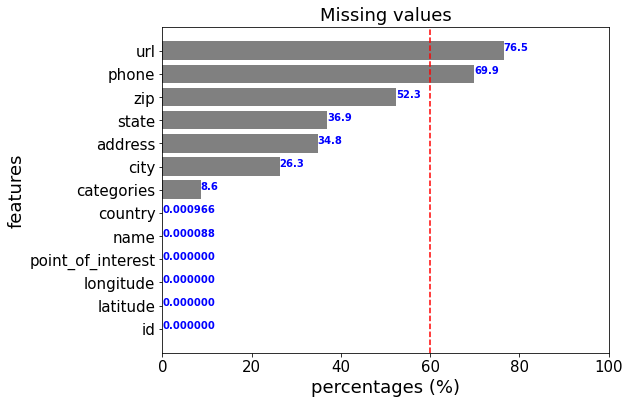

In [6]:
df = df_train
# Count the missing values in each feature
missing = df.isna().sum()/df.shape[0]*100
print(missing.sort_values())

# Plot the percentages of missing values for each feature
import matplotlib.ticker as mtick
tmp = df.isna().sum().sort_values()
fig, ax = plt.subplots(figsize=(8,6))

y = tmp/len(df)*100
ax.barh(tmp.index, y, color='gray')
ax.set_title("Missing values", fontsize=18)
ax.axvline(x=60,color='r',linestyle='--')
# ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.tick_params(axis='both', labelsize=15 )
ax.set_ylabel('features', fontsize=18)
ax.set_xlabel('percentages (%)', fontsize=18)
ax.set_xlim(0,100)

for index, value in enumerate(y):
    if value < 1:
        ax.text(value, index, '{:.6f}'.format(value), color = 'blue', fontweight = 'bold')
    else:
        ax.text(value, index, '{:.1f}'.format(value), color = 'blue', fontweight = 'bold')
plt.show()

Should drop the url and phone columns since more than 60% are missing.

## Features in `train.csv`

In [7]:
df.columns

Index(['id', 'name', 'latitude', 'longitude', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories', 'point_of_interest'],
      dtype='object')

## `id`

In [8]:
# each value in `id` is unique.
print("Each value in `id` is unique:", len(df.id.unique()) == df.shape[0])

Each value in `id` is unique: True


## `latitude` and `longitude`

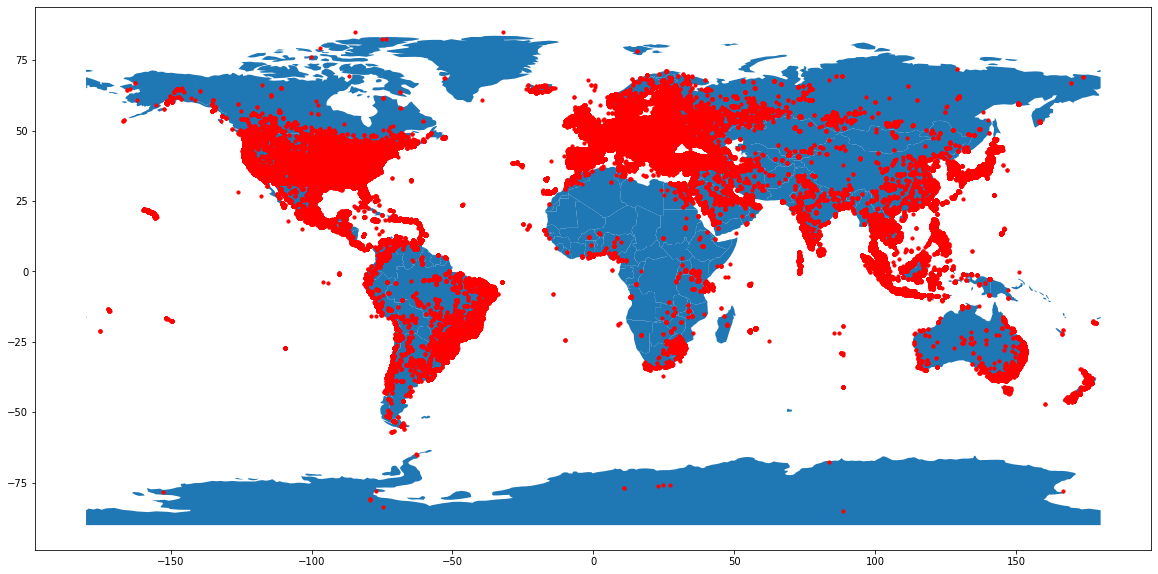

In [9]:
# simple sketch
# fig, ax = plt.subplots(figsize=(40,25))
# ax.scatter(df_train['longitude'],df_train['latitude'])
# ax.set_xlabel('longitude',fontsize=40)
# ax.set_ylabel('latitude',fontsize=40)
# ax.tick_params(axis='both', labelsize=40)
# ax.grid()
# plt.show()

# fancy plot
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df_train.copy(), geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(20, 12))
world.plot(figsize=(20, 12), ax=ax)
gdf.plot(ax=ax, marker='o', color='red', markersize=10)

fig.savefig("./train_coords.png")
plt.show()

## `name`

This column has different languages. 

In [10]:
df['name']

0                    Café Stad Oudenaarde
1                          Carioca Manero
2                        ร้านตัดผมการาเกด
3                                Turkcell
4                 Restaurante Casa Cofiño
                        ...              
1138807                              青ガエル
1138808                      Deshon Place
1138809    İzmir Adnan Menderes Havaalanı
1138810                             焼肉 和家
1138811                       Waihi Beach
Name: name, Length: 1138812, dtype: object

In [11]:
# !pip install langdetect
from langdetect import detect

In [12]:
# Takes a few minutes.
# flag = 0
# lang = []
# for row in df['name'].dropna():
#     if flag > 20:
#         break
#     try:
#         lang.append(detect(row))
#     except:
#         flag += 1
#         language = "error"
#         print("This row throws and error:", row)
# print(set(lang))

## `country` 

Data availability


(10,)


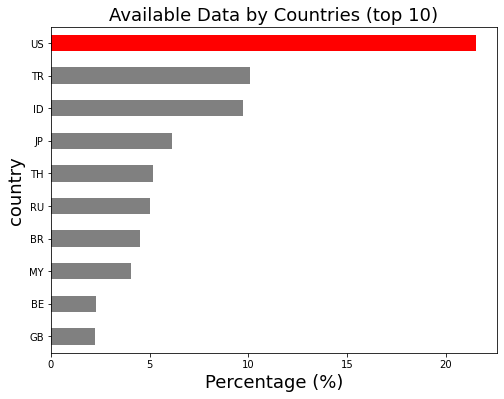

In [13]:
country_stats = df['country'].value_counts()*100/df['country'].value_counts().sum()
country_stats = country_stats.head(10).sort_values()
print(country_stats.shape)

fig, ax = plt.subplots(figsize=(8,6))
color = ["gray"]*len(country_stats.index)
color[-1] = "red"
country_stats.plot(kind = 'barh', ax = ax, color = color)

ax.set_title("Available Data by Countries (top 10)", fontsize = 18)
ax.set_ylabel('country', fontsize = 18)
ax.set_xlabel('Percentage (%)', fontsize = 18)
plt.show()

## `point_of_interest`

In [14]:
df['point_of_interest'].value_counts()

P_fb339198a31db3    332
P_3a3fbd26e16269    199
P_f70a0977377171    166
P_9290e406eb58ac    145
P_fbe61733fcdebe    132
                   ... 
P_ed44fbd056eb4d      1
P_6601e86230f550      1
P_36404ebf8565ee      1
P_3270f1f5b135b9      1
P_ea6578bf39b406      1
Name: point_of_interest, Length: 739972, dtype: int64

In [15]:
tmp = df[df['point_of_interest']=='P_399ab9d64f2a2e'].sort_values(by='point_of_interest')
tmp.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
1517,E_005b1a6f97ca7b,Nationwide Insurance,39.962014,-82.885847,583 S Yearling Rd,Columbus,OH,43213,US,http://t.co/4eDIQ4ptQn,+16145752643,Financial or Legal Services,P_399ab9d64f2a2e
526905,E_7667106372e795,Nationwide Insurance - Monica M Radke,37.576416,-77.443130,11428 Belvedere Vista Ln,North Chesterfield,VA,23235,US,http://t.co/4eDIQ4ptQn,+18046585233,Financial or Legal Services,P_399ab9d64f2a2e
539146,E_79295816ef8549,Nationwide Insurance - Ruben Saucedo Agency,32.756500,-96.822220,1112 N Zang Blvd,Dallas,TX,75203,US,http://t.co/4eDIQ4ptQn,+12149428500,Financial or Legal Services,P_399ab9d64f2a2e
543303,E_7a17b3160fa7eb,Nationwide Insurance - Kent Kiesewetter,30.644263,-94.873782,8 N Main St,Kingwood,TX,77339,US,http://t.co/4eDIQ4ptQn,+12815487003,Financial or Legal Services,P_399ab9d64f2a2e
582169,E_82db401372a141,Nationwide Insurance - Alison Maureen Rielli A...,38.607881,-121.435018,2251 Harvard St,Sacramento,CA,95815,US,http://t.co/4eDIQ4ptQn,+19169152744,Financial or Legal Services,P_399ab9d64f2a2e


In [16]:
tmp = df[df['point_of_interest']=='P_ce9291000a8f0b'].sort_values(by='point_of_interest')
tmp.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
19594,E_04656287079d09,"Cara J. Lasley, MD",39.779379,-75.555298,1600 Rockland Rd,Wilmington,DE,19803,US,https://findaprovider.nemours.org/details/1877...,+18004164441,Doctor's Offices,P_ce9291000a8f0b
647358,E_917cf32095d31e,"Naomi F. Lauriello, MD",39.779379,-75.555298,1600 Rockland Rd,Wilmington,DE,19803,US,https://findaprovider.nemours.org/details/2202...,+18004164441,Doctor's Offices,P_ce9291000a8f0b
648768,E_91ceb13234ef44,"Stephen J. Falchek, MD",39.779379,-75.555298,1600 Rockland Rd,Wilmington,DE,19803,US,https://findaprovider.nemours.org/details/973/...,+18004164441,Doctor's Offices,P_ce9291000a8f0b
670884,E_96b3145a11cf21,"Steven L. Blumer, MD",39.779379,-75.555298,1600 Rockland Rd,Wilmington,DE,19803,US,https://findaprovider.nemours.org/details/787/...,+18004164441,Doctor's Offices,P_ce9291000a8f0b
675333,E_97b2cb975f93b7,"Takeshi Tsuda, MD",39.779379,-75.555298,1600 Rockland Rd,Wilmington,DE,19803,US,https://findaprovider.nemours.org/details/1261...,+18004164441,Doctor's Offices,P_ce9291000a8f0b


# The US data in `train.csv`

We focus on the US data in `train.csv` to have a smaller data set.

In [17]:
df_us = df[df['country']=='US']

In [18]:
df_us.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245284 entries, 8 to 1138808
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 245284 non-null  object 
 1   name               245283 non-null  object 
 2   latitude           245284 non-null  float64
 3   longitude          245284 non-null  float64
 4   address            188824 non-null  object 
 5   city               236241 non-null  object 
 6   state              239373 non-null  object 
 7   zip                213277 non-null  object 
 8   country            245284 non-null  object 
 9   url                99477 non-null   object 
 10  phone              131597 non-null  object 
 11  categories         232133 non-null  object 
 12  point_of_interest  245284 non-null  object 
dtypes: float64(2), object(11)
memory usage: 26.2+ MB


## Missing values

id                    0.000000
latitude              0.000000
longitude             0.000000
country               0.000000
point_of_interest     0.000000
name                  0.000408
state                 2.409860
city                  3.686747
categories            5.361540
zip                  13.048955
address              23.018216
phone                46.349130
url                  59.444155
dtype: float64


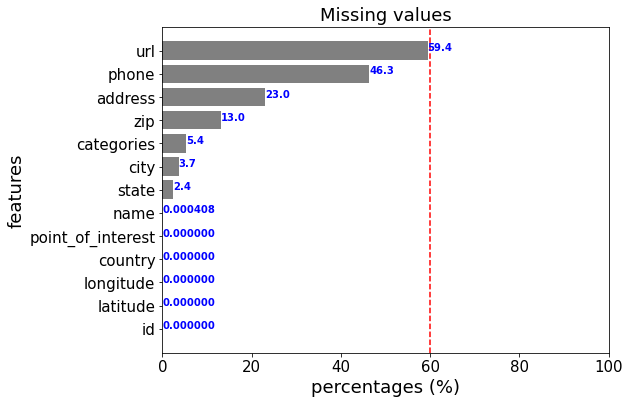

In [19]:
df = df_us
# Count the missing values in each feature
missing = df.isna().sum()/df.shape[0]*100
print(missing.sort_values())

# Plot the percentages of missing values for each feature
import matplotlib.ticker as mtick
tmp = df.isna().sum().sort_values()
fig, ax = plt.subplots(figsize=(8,6))

y = tmp/len(df)*100
ax.barh(tmp.index, y, color='gray')
ax.set_title("Missing values", fontsize=18)
ax.axvline(x=60,color='r',linestyle='--')
# ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.tick_params(axis='both', labelsize=15 )
ax.set_ylabel('features', fontsize=18)
ax.set_xlabel('percentages (%)', fontsize=18)
ax.set_xlim(0,100)

for index, value in enumerate(y):
    if value < 1:
        ax.text(value, index, '{:.6f}'.format(value), color = 'blue', fontweight = 'bold')
    else:
        ax.text(value, index, '{:.1f}'.format(value), color = 'blue', fontweight = 'bold')
plt.show()

Throw away the `url` column because about 60% data are missing.

In [20]:
df_train[df_train['country'].isna()].head(3)

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
45891,E_0a44b45f734139,"Markham, Maerua Mall",-22.583108,17.093568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Men's Stores,P_845763d172f88e
201697,E_2d417f61d76741,Wernhill Park,-22.567297,17.082069,NaN,Windhoek,Khomas,NaN,NaN,NaN,NaN,Shopping Malls,P_5ffceb1c2ec3cd
253807,E_3900936ca2996a,Hilton Windhoek,-22.570327,17.085307,Rev. Michael Scott Street,Windhoek,Khomas,70,NaN,http://windhoek.hilton.com,612962929,NaN,P_d7df3f321a984f


In [21]:
df_train[df_train['name'].isna()].head(3)

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
750648,E_a8a20800af4423,NaN,40.822332,-96.689102,NaN,NaN,AK,NaN,US,NaN,NaN,NaN,P_be5d12315d8588


## Features in the US set

In [22]:
# # simple sketch
# df = df_us
# fig, ax = plt.subplots(figsize=(20,11))
# ax.scatter(df['longitude'],df['latitude'])
# ax.set_xlabel('longitude',fontsize=20)
# ax.set_ylabel('latitude',fontsize=20)
# ax.tick_params(axis='both', labelsize=20)
# ax.grid()
# plt.show()

### `name`

In [23]:
# # Takes a few minutes.
# df = df_us
# flag = 0
# lang = []
# for row in df['name'].dropna():
#     if flag > 20:
#         break
#     try:
#         lang.append(detect(row))
#     except:
#         flag += 1
#         language = "error"
#         print("This row throws and error:", row)
# print(set(lang))

In [24]:
tmp = df_us['name'].sort_values()
tmp

622268                               "#208 \"Comfort Inn\""
769105                  "Access Health Care, LLC \"Adams\""
885613                 "Access Health Care, LLC \"Howell\""
779271    "Alfredo's Beach Club's \"Sunsets On The Beach...
493745                       "AmVets Post #2 \"Post Home\""
                                ...                        
150203                                   Kaleigh's Krib
513853                                              Heaven
121260                                  ﻿V Bar Ultra Lounge
474973                                   💇 Hair By CHiiNK 💋
750648                                                  NaN
Name: name, Length: 245284, dtype: object

### `point_of_interest`

In [25]:
print('Number of (unique) POIs : {:8d}'.format(len(df_train['point_of_interest'].unique())))
print('Number of (unique) ids  : {:8d}'.format(len(df_train['id'].unique())))

Number of (unique) POIs :   739972
Number of (unique) ids  :  1138812


In [26]:
df_us['point_of_interest'].value_counts().head(10)

P_399ab9d64f2a2e    58
P_ce9291000a8f0b    46
P_a3fddc2f0a77e7    37
P_d89437d5f1169c    35
P_5cf56bf7bdf7ae    29
P_fff25ec89e22da    28
P_0c880e80aaa19f    26
P_bae8584591fe1a    26
P_1e8e17b542e178    25
P_4efd9da6085caf    25
Name: point_of_interest, dtype: int64

In [27]:
# Noise: same POI with different physical places; sorted by 'name'.
df_us.loc[df_us['point_of_interest']=='P_399ab9d64f2a2e',
          ['name','latitude','longitude','city','state','zip','categories','point_of_interest']].sort_values(by='name').head(10)

,name,latitude,longitude,city,state,zip,categories,point_of_interest
642307,Gregg Steiner - Nationwide Insurance & Financi...,33.607341,-117.877248,Newport Beach,CA,92660,Financial or Legal Services,P_399ab9d64f2a2e
268102,James S Wills Agency - Nationwide Insurance,34.002130,-81.772107,Saluda,SC,29138,NaN,P_399ab9d64f2a2e
1517,Nationwide Insurance,39.962014,-82.885847,Columbus,OH,43213,Financial or Legal Services,P_399ab9d64f2a2e
585453,Nationwide Insurance,39.280624,-76.611005,Baltimore,MD,21230,Financial or Legal Services,P_399ab9d64f2a2e
233839,Nationwide Insurance,41.224360,-73.071814,Milford,CT,06460,Financial or Legal Services,P_399ab9d64f2a2e
205941,Nationwide Insurance,35.726227,-79.465096,Siler City,NC,27344,Financial or Legal Services,P_399ab9d64f2a2e
1109854,Nationwide Insurance,37.771586,-122.276649,Alameda,CA,94501,Financial or Legal Services,P_399ab9d64f2a2e
147100,Nationwide Insurance,35.991922,-80.028573,High Point,NC,27262,Financial or Legal Services,P_399ab9d64f2a2e
416436,Nationwide Insurance - AOK Agency,41.594937,-83.647413,Toledo,OH,43614,Financial or Legal Services,P_399ab9d64f2a2e
818454,Nationwide Insurance - Alexandra Ramos Agency,40.145845,-82.945719,Westerville,OH,43082,Financial or Legal Services,P_399ab9d64f2a2e


In [28]:
# Noise: same POI with different physical places; sorted by 'state'.
df_us.loc[df_us['point_of_interest']=='P_399ab9d64f2a2e',
          ['name','latitude','longitude','city','state','zip','categories','point_of_interest']].sort_values(by='state').head(10)

,name,latitude,longitude,city,state,zip,categories,point_of_interest
161948,Nationwide Insurance - Bruce Sargent Insurance...,34.262962,-92.084663,White Hall,AR,71602,Financial or Legal Services,P_399ab9d64f2a2e
193359,Nationwide Insurance - Gates Ins Inc,33.396255,-111.684190,Mesa,AZ,85206,Financial or Legal Services,P_399ab9d64f2a2e
1109854,Nationwide Insurance,37.771586,-122.276649,Alameda,CA,94501,Financial or Legal Services,P_399ab9d64f2a2e
642307,Gregg Steiner - Nationwide Insurance & Financi...,33.607341,-117.877248,Newport Beach,CA,92660,Financial or Legal Services,P_399ab9d64f2a2e
582169,Nationwide Insurance - Alison Maureen Rielli A...,38.607881,-121.435018,Sacramento,CA,95815,Financial or Legal Services,P_399ab9d64f2a2e
52883,Nationwide Insurance - Ronald Scott Madden Agency,36.828552,-119.701050,Clovis,CA,93612,Financial or Legal Services,P_399ab9d64f2a2e
630340,Nationwide Insurance - Colorado Insurance Group,39.678352,-105.082184,Denver,CO,80246,Financial or Legal Services,P_399ab9d64f2a2e
233839,Nationwide Insurance,41.224360,-73.071814,Milford,CT,06460,Financial or Legal Services,P_399ab9d64f2a2e
272625,Nationwide Insurance - Bryan Slater Agency,33.740365,-84.392853,Atlanta,GA,30312,Financial or Legal Services,P_399ab9d64f2a2e
1009171,Nationwide Insurance - Nicholas Greene Agency,34.111238,-84.039890,Sugar Hill,GA,30518,Financial or Legal Services,P_399ab9d64f2a2e


In [29]:
# Noise: same POI with different physical places; sorted by 'city'.
df_us.loc[df_us['point_of_interest']=='P_399ab9d64f2a2e',
          ['name','latitude','longitude','city','state','zip','categories','point_of_interest']].sort_values(by='city').head(10)
# df_us[df_us['name']=='CVS'].sort_values(by='point_of_interest').head()

,name,latitude,longitude,city,state,zip,categories,point_of_interest
1109854,Nationwide Insurance,37.771586,-122.276649,Alameda,CA,94501,Financial or Legal Services,P_399ab9d64f2a2e
272625,Nationwide Insurance - Bryan Slater Agency,33.740365,-84.392853,Atlanta,GA,30312,Financial or Legal Services,P_399ab9d64f2a2e
671771,Nationwide Insurance - Corrigan Insurance Agen...,39.280465,-76.610727,Baltimore,MD,21230,Financial or Legal Services,P_399ab9d64f2a2e
585453,Nationwide Insurance,39.280624,-76.611005,Baltimore,MD,21230,Financial or Legal Services,P_399ab9d64f2a2e
472930,Nationwide Insurance - Robertson Financial Group,39.280121,-80.233749,Bridgeport,WV,26330,Financial or Legal Services,P_399ab9d64f2a2e
748106,Nationwide Insurance - Michael Glick Agency Inc,36.080887,-79.474373,Burlington,NC,27215,Financial or Legal Services,P_399ab9d64f2a2e
675426,Nationwide Insurance - Bouldin Williams Agency...,36.072111,-79.427535,Burlington,NC,27215,Financial or Legal Services,P_399ab9d64f2a2e
418003,Nationwide Insurance - Mcglothin Insurance And Co,39.603920,-82.918571,Circleville,OH,43113,Financial or Legal Services,P_399ab9d64f2a2e
52883,Nationwide Insurance - Ronald Scott Madden Agency,36.828552,-119.701050,Clovis,CA,93612,Financial or Legal Services,P_399ab9d64f2a2e
303528,Nationwide Insurance - Thomas S Davis,36.201122,-76.767464,Colerain,NC,27924,Financial or Legal Services,P_399ab9d64f2a2e


### `state`

In [30]:
df_us['state'].unique()

array(['CA', 'GA', 'NM', 'FL', 'PA', 'VA', 'NJ', 'OH', 'WI', 'MO', 'SC',
       'TN', 'OR', 'AZ', 'TX', 'MD', 'NY', 'MI', 'MA', 'NC', 'UT', 'IN',
       'IL', nan, 'Calif', 'NV', 'KS', 'MS', 'WA', 'AL', 'OK', 'AR', 'CT',
       'KY', 'NE', 'WV', 'CO', 'HI', 'ID', 'LA', 'MN', 'MT', 'ME', 'NH',
       'nv', 'WY', 'IA', 'DE', 'RI', 'VT', 'il', 'ND', 'AK', 'DC', 'SD',
       'D.C.', 'Ia', 'Ohio', 'Nj', 'Georgia', 'Nc', 'de', 'New York',
       'New Jersey', 'Ca', 'texas', 'Pa', 'Missouri', 'pa', 'Tx',
       'Connecticut', 'Ok', 'co', 'wi', 'Va', 'Az', 'ca',
       'North Carolina', 'Tennessee', 'Pennsylvania', 'Florida',
       'Massachusetts', 'tx', 'Kansas', 'Ny', 'Ga', 'Virginia', 'fl',
       'Tamaulipas', 'LOUISIANA', 'nc', 'Il', 'California', 'Ma', 'PR',
       'wa', 'Maryland', 'ny', 'Illinois', 'District of Columbia', 'Iowa',
       'Texas', 'CE', 'Wisconsin', 'Fl', 'mi', 'az', 'Arkansas',
       'Capital Region of Denmark', 'Minnesota', 'Md', 'Tn',
       'Mississippi', 'Idaho', 

In [31]:
# Drop these.
filter_set = ['国外','UK','CE','ON/NY','Capital Region of Denmark','BCN','Tamaulipas','NU']
df_us[df_us['state'].isin(filter_set)]

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
75113,E_10d0a514fabcc6,AutoZone,26.080340,-98.304671,Blvd. Hidalgo # 1750 Col. Morelos,Reynosa,Tamaulipas,88651,US,https://www.autozone.com.mx,8999238990,Automotive Shops,P_caaec985490160
153657,E_226eb110eb0a4e,Evevideo 8,40.771182,-73.977953,Av Pedro Alves,Acopiara,CE,63560-000,US,NaN,NaN,Conferences,P_ac5a6fb63841d4
182570,E_28f6a8c1810d42,Copenhagen Airport (CPH),55.613190,12.647946,NaN,Copenhagen,Capital Region of Denmark,NaN,US,NaN,NaN,Airports,P_de322dff6e3a8b
251224,E_3869cbc132af4a,Evevideo 1,40.770792,-73.976183,Av Pedro Alves,Acopiara,CE,63560-000,US,NaN,NaN,Conferences,P_ac5a6fb63841d4
295772,E_426b4d3c7f12cf,Evevideo 7,40.771361,-73.977191,Av Pedro Alves,Acopiara,CE,63560-000,US,NaN,NaN,Conferences,P_ac5a6fb63841d4
361799,E_514da8554757c7,Dulceria Alejandra,32.659417,-115.486806,NaN,Mexicali,BCN,NaN,US,NaN,NaN,Candy Stores,P_363b19f021fb6f
600387,E_86ee21433a06ce,Canada / US Border,42.907269,-78.907035,Peace Bridge,Fort Erie/Buffalo,ON/NY,NaN,US,NaN,NaN,Border Crossings,P_856fc237546080
738444,E_a5e59da858ec99,Wegmans Pharmacy,42.145954,-77.062603,24 S. Bridge St.,Corning,NU,14830,US,NaN,NaN,Pharmacies,P_fcf4397457178a
886639,E_c72776cf1d131b,boiling crab,37.302755,-121.864208,"1631 E Capitol Expy San Jose, CA 95121-1826 (4...",海外,国外,95121,US,NaN,NaN,NaN,P_0cc38b5ae552c4
918520,E_ce51ff08bea33e,"Albemarle Art Gallery, London UK",33.636645,-84.437706,Albermarle,London,UK,NaN,US,NaN,NaN,NaN,P_a2569d6f26dd5c


#### Notes on the `point_of_interest` feature:

https://www.kaggle.com/competitions/foursquare-location-matching/discussion/318967#1783581

In [32]:
# mask = (df_train['country'] == 'US')
# total     = len(df_train[df_train['country'] == 'US'])
# zip_len   = len(df_train[df_train['zip'].isna()  & mask])
# state_len = len(df_train[df_train['state'].isna()& mask])
# city_len  = len(df_train[df_train['city'].isna() & mask])
# zsc_len   = len(df_train[df_train['zip'].isna() | df_train['state'].isna() | df_train['city'].isna() | mask])
# print(total)
# print(zip_len/total)
# print(state_len/total)
# print(city_len/total)
# print(zsc_len/total)

### `categories`

In [33]:
df_us.categories.sample(30)

383852                                     Basketball Courts
953666                                                 Parks
898963                                             Mountains
400118           Residential Buildings (Apartments / Condos)
809231                                       Sandwich Places
449706                                          Gas Stations
252305        Automotive Shops, Auto Workshops, Auto Garages
982379                                          Auto Garages
643076                                           Non-Profits
225870                                                Hotels
107222                                                Hotels
531282                                            Roof Decks
186114                                               Lawyers
73340                                                    NaN
39507                    French Restaurants, Delis / Bodegas
1058086                                        Tech Startups
912820                  

# Exploring (US) `pairs.csv`
This is a subset of pairs from `train.csv`. The value of `match` is "True" if an only if the pair has the same `point_of_interest` value in `train.csv`. We will focus on the US pairs. 

In [34]:
df_pairs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578907 entries, 0 to 578906
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id_1          578907 non-null  object 
 1   name_1        578907 non-null  object 
 2   latitude_1    578907 non-null  float64
 3   longitude_1   578907 non-null  float64
 4   address_1     475383 non-null  object 
 5   city_1        512928 non-null  object 
 6   state_1       452316 non-null  object 
 7   zip_1         359509 non-null  object 
 8   country_1     578899 non-null  object 
 9   url_1         231806 non-null  object 
 10  phone_1       270022 non-null  object 
 11  categories_1  562613 non-null  object 
 12  id_2          578907 non-null  object 
 13  name_2        578907 non-null  object 
 14  latitude_2    578907 non-null  float64
 15  longitude_2   578907 non-null  float64
 16  address_2     312497 non-null  object 
 17  city_2        367490 non-null  object 
 18  stat

In [35]:
df_pairs_us = df_pairs[(df_pairs.country_1=='US') & (df_pairs.country_2=='US')]

In [36]:
df = df_pairs_us.copy()

In [37]:
df.shape

(117708, 25)

In [38]:
df['state_1'].isna().count(), df['state_2'].isna().count()

(117708, 117708)

## True vs. False in the `match` feature

In [39]:
print(df.groupby('match')['match'].count())

match
False    33097
True     84611
Name: match, dtype: int64


In [40]:
a,b = zip(df.groupby('match')['match'].count())
print(b[0]/(a[0]+b[0]))

0.7188211506439665


## Engineering the state code in `state_1` and `state_2`

In [41]:
print(df['state_1'].unique())
print(df['state_2'].unique())

['CA' 'GA' 'NM' 'FL' 'VA' 'TN' 'NJ' 'UT' 'IN' 'NC' 'WI' nan 'NV' 'KS' 'MA'
 'MS' 'AZ' 'MI' 'NY' 'TX' 'IL' 'AL' 'PA' 'OK' 'AR' 'KY' 'MO' 'WV' 'CO'
 'NE' 'OH' 'OR' 'MT' 'CT' 'NH' 'Calif' 'MD' 'HI' 'WA' 'WY' 'RI' 'VT' 'IA'
 'MN' 'LA' 'SC' 'ND' 'DE' 'DC' 'SD' 'AK' 'D.C.' 'ID' 'ME' 'New York'
 'North Carolina' 'tx' 'Il' 'Virginia' 'District of Columbia' 'Ma' 'Ohio'
 'Texas' 'Md' 'Ca' 'California' 'Kentucky' 'CE' 'Kansas' 'In' 'Arizona'
 'il' 'Illinois' 'nj' 'Missouri' 'ON/NY' 'Wisconsin' 'Iowa'
 'South Carolina' 'Georgia' 'Tennessee' 'Fl' 'Ia' 'Maryland']
['CA' 'GA' 'NM' 'FL' 'VA' 'TN' nan 'NJ' 'Calif' 'UT' 'IN' 'NC' 'WI' 'NV'
 'KS' 'MA' 'MS' 'AZ' 'MI' 'NY' 'TX' 'IL' 'AL' 'PA' 'OK' 'AR' 'KY' 'WV'
 'CO' 'NE' 'Fl' 'OH' 'OR' 'MT' 'SC' 'CT' 'NH' 'MO' 'MD' 'HI' 'WA' 'WY'
 'VT' 'IA' 'MN' 'LA' 'ND' 'DE' 'Pennsylvania' 'Illinois' 'DC' 'SD'
 'Nevada' 'AK' 'ID' 'va' 'Il' 'ME' 'Texas' 'Arkansas' 'RI' 'Ga' 'New York'
 'D.C.' 'Florida' 'fl' 'oh' 'Ca' 'Al' 'tx' 'Michigan' 'ny' 'Tx' 'Ohio'
 'New Jersey' '

In [42]:
df[df['state_1']=='ON/NY']

,id_1,name_1,latitude_1,longitude_1,address_1,city_1,state_1,zip_1,country_1,url_1,...,longitude_2,address_2,city_2,state_2,zip_2,country_2,url_2,phone_2,categories_2,match
305701,E_86ee21433a06ce,Canada / US Border,42.907269,-78.907035,Peace Bridge,Fort Erie/Buffalo,ON/NY,NaN,US,NaN,...,-78.871142,NaN,NaN,NaN,NaN,US,NaN,NaN,Bed & Breakfasts,True
305703,E_86ee21433a06ce,Canada / US Border,42.907269,-78.907035,Peace Bridge,Fort Erie/Buffalo,ON/NY,NaN,US,NaN,...,-78.734970,NaN,NaN,NaN,NaN,US,NaN,NaN,General Travel,True


In [43]:
state = pd.read_csv('./data/state-code.csv', header=None)
state.head()
state.columns=['state','code']
state.head()
state['state'] = state['state'].str.upper()
state.head()

,state,code
0,ALABAMA,AL
1,ALASKA,AK
2,ARIZONA,AZ
3,ARKANSAS,AR
4,CALIFORNIA,CA


In [44]:
dict_lookup = dict(zip(state['state'],state['code']))
dict_lookup['CALIF'] = 'CA'
dict_lookup['D.C.']  = 'DC'

In [45]:
df = df.dropna(subset=['state_1','state_2'])
print(df.shape)
df['state_1'] = df['state_1'].str.upper()
df['state_2'] = df['state_2'].str.upper()

for x in dict_lookup.keys():
    
    df.loc[df["state_1"] == x, "state_1"] = dict_lookup[x]
    df.loc[df["state_2"] == x, "state_2"] = dict_lookup[x]
    
print(df['state_1'].unique())
print(df['state_2'].unique())

(112881, 25)
['CA' 'GA' 'NM' 'FL' 'VA' 'TN' 'NJ' 'UT' 'IN' 'NC' 'WI' 'NV' 'KS' 'MA'
 'MS' 'AZ' 'MI' 'NY' 'TX' 'IL' 'AL' 'PA' 'OK' 'AR' 'KY' 'WV' 'CO' 'NE'
 'OH' 'OR' 'MT' 'CT' 'NH' 'MO' 'MD' 'HI' 'WA' 'WY' 'VT' 'IA' 'MN' 'LA'
 'SC' 'ND' 'DE' 'DC' 'SD' 'AK' 'ID' 'ME' 'RI' 'CE']
['CA' 'GA' 'NM' 'FL' 'VA' 'TN' 'NJ' 'UT' 'IN' 'NC' 'WI' 'NV' 'KS' 'MA'
 'MS' 'AZ' 'MI' 'NY' 'TX' 'IL' 'AL' 'PA' 'OK' 'AR' 'KY' 'WV' 'CO' 'NE'
 'OH' 'OR' 'MT' 'CT' 'NH' 'MO' 'MD' 'HI' 'WA' 'WY' 'VT' 'IA' 'MN' 'LA'
 'SC' 'ND' 'DE' 'DC' 'SD' 'AK' 'ID' 'ME' 'RI' 'UK' 'CE' 'NU' '国外']


In [46]:
drop_list = ['UK', 'CE', 'NU', '国外']
df = df[df['state_1'].isin(drop_list)==False] 
df = df[df['state_2'].isin(drop_list)==False] 
print(df['state_1'].unique())
print(df['state_2'].unique())

['CA' 'GA' 'NM' 'FL' 'VA' 'TN' 'NJ' 'UT' 'IN' 'NC' 'WI' 'NV' 'KS' 'MA'
 'MS' 'AZ' 'MI' 'NY' 'TX' 'IL' 'AL' 'PA' 'OK' 'AR' 'KY' 'WV' 'CO' 'NE'
 'OH' 'OR' 'MT' 'CT' 'NH' 'MO' 'MD' 'HI' 'WA' 'WY' 'VT' 'IA' 'MN' 'LA'
 'SC' 'ND' 'DE' 'DC' 'SD' 'AK' 'ID' 'ME' 'RI']
['CA' 'GA' 'NM' 'FL' 'VA' 'TN' 'NJ' 'UT' 'IN' 'NC' 'WI' 'NV' 'KS' 'MA'
 'MS' 'AZ' 'MI' 'NY' 'TX' 'IL' 'AL' 'PA' 'OK' 'AR' 'KY' 'WV' 'CO' 'NE'
 'OH' 'OR' 'MT' 'CT' 'NH' 'MO' 'MD' 'HI' 'WA' 'WY' 'VT' 'IA' 'MN' 'LA'
 'SC' 'ND' 'DE' 'DC' 'SD' 'AK' 'ID' 'ME' 'RI']


In [47]:
tmp1 = df['state_1'].unique()
tmp2 = df['state_2'].unique()
print(set(state['code']).difference(set(tmp1)))
print(set(state['code']).difference(set(tmp2)))

{'PR', 'VI'}
{'PR', 'VI'}


## Adding similarity features

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112876 entries, 3 to 578904
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id_1          112876 non-null  object 
 1   name_1        112876 non-null  object 
 2   latitude_1    112876 non-null  float64
 3   longitude_1   112876 non-null  float64
 4   address_1     99868 non-null   object 
 5   city_1        111756 non-null  object 
 6   state_1       112876 non-null  object 
 7   zip_1         107483 non-null  object 
 8   country_1     112876 non-null  object 
 9   url_1         64751 non-null   object 
 10  phone_1       77194 non-null   object 
 11  categories_1  110710 non-null  object 
 12  id_2          112876 non-null  object 
 13  name_2        112876 non-null  object 
 14  latitude_2    112876 non-null  float64
 15  longitude_2   112876 non-null  float64
 16  address_2     80649 non-null   object 
 17  city_2        110554 non-null  object 
 18  stat

In [49]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

### name similarity

In [50]:
# name similarity array;
sim_arr = []
for i in range(len(df)):
    a = df.iloc[[i]].loc[:,'name_1'].values[0]
    b = df.iloc[[i]].loc[:,'name_2'].values[0]
    sim = similar(a,b)
    sim_arr.append(sim)
    if i%5000==0: 
        print('{}; '.format(i), end='')
    if i%50000==0:
        print()

0; 
5000; 10000; 15000; 20000; 25000; 30000; 35000; 40000; 45000; 50000; 
55000; 60000; 65000; 70000; 75000; 80000; 85000; 90000; 95000; 100000; 
105000; 110000; 

In [51]:
df['name_similarity'] = sim_arr

### geo-distance similarity

In [52]:
# geo-distance array;
dist_arr = []
for i in range(len(df)):
    a = df.iloc[[i]].loc[:,['latitude_1','longitude_1']].values[0]
    b = df.iloc[[i]].loc[:,['latitude_2','longitude_2']].values[0]
    d = np.linalg.norm(a-b)
    dist_arr.append(d)
    if i%5000==0: 
        print('{}; '.format(i), end='')
    if i%50000==0:
        print()
# dist_arr

0; 
5000; 10000; 15000; 20000; 25000; 30000; 35000; 40000; 45000; 50000; 
55000; 60000; 65000; 70000; 75000; 80000; 85000; 90000; 95000; 100000; 
105000; 110000; 

In [53]:
df['geo_distance'] = dist_arr

### state similarity

In [54]:
# state similarity array;
sim_arr = []
for i in range(len(df)):
    a = df.iloc[[i]].loc[:,'state_1'].values[0]
    b = df.iloc[[i]].loc[:,'state_2'].values[0]
    sim = similar(a,b)
    sim_arr.append(sim)
    if i%5000==0: 
        print('{}; '.format(i), end='')
    if i%50000==0:
        print()
df['state_sim'] = sim_arr

0; 
5000; 10000; 15000; 20000; 25000; 30000; 35000; 40000; 45000; 50000; 
55000; 60000; 65000; 70000; 75000; 80000; 85000; 90000; 95000; 100000; 
105000; 110000; 

In [55]:
# df.rename(columns={'name_similarity':'name_sim'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112876 entries, 3 to 578904
Data columns (total 28 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id_1             112876 non-null  object 
 1   name_1           112876 non-null  object 
 2   latitude_1       112876 non-null  float64
 3   longitude_1      112876 non-null  float64
 4   address_1        99868 non-null   object 
 5   city_1           111756 non-null  object 
 6   state_1          112876 non-null  object 
 7   zip_1            107483 non-null  object 
 8   country_1        112876 non-null  object 
 9   url_1            64751 non-null   object 
 10  phone_1          77194 non-null   object 
 11  categories_1     110710 non-null  object 
 12  id_2             112876 non-null  object 
 13  name_2           112876 non-null  object 
 14  latitude_2       112876 non-null  float64
 15  longitude_2      112876 non-null  float64
 16  address_2        80649 non-null   obje

### address+city+state+zip




In [56]:
df = pd.read_csv("./data/pairs_us_sim.csv")

FileNotFoundError: [Errno 2] No such file or directory: './data/pairs_us_sim.csv'

In [ ]:
df.columns

In [ ]:
df.fillna('', inplace=True)

In [ ]:
# df['add_city_state_zip_1'] = df['address_1'] + df['city_1'] + df['state_1'] + df['zip_1']

In [ ]:
# df['add_city_state_zip_2'] = df['address_2'] + df['city_2'] + df['state_2'] + df['zip_2']

In [ ]:
# df[['add_city_state_zip_1','add_city_state_zip_2']]

In [ ]:
# address similarity array;
sim_arr = []
for i in range(len(df)):
    a = df.iloc[[i]].loc[:,'address_1'].values[0]
    b = df.iloc[[i]].loc[:,'address_2'].values[0]
    sim = similar(a,b)
    sim_arr.append(sim)
    if i%5000==0: 
        print('{}; '.format(i), end='')
    if i%50000==0:
        print()
df['add_sim'] = sim_arr

In [ ]:
# city similarity array;
sim_arr = []
for i in range(len(df)):
    a = df.iloc[[i]].loc[:,'city_1'].values[0]
    b = df.iloc[[i]].loc[:,'city_2'].values[0]
    sim = similar(a,b)
    sim_arr.append(sim)
    if i%5000==0: 
        print('{}; '.format(i), end='')
    if i%50000==0:
        print()
df['city_sim'] = sim_arr

In [ ]:
# zip similarity array;
sim_arr = []
for i in range(len(df)):
    a = df.iloc[[i]].loc[:,'zip_1'].values[0]
    b = df.iloc[[i]].loc[:,'zip_2'].values[0]
    sim = similar(a,b)
    sim_arr.append(sim)
    if i%5000==0: 
        print('{}; '.format(i), end='')
    if i%50000==0:
        print()
df['zip_sim'] = sim_arr

In [ ]:
df['acsz_1'] = df['address_1'] + ' ' + df['city_1'] + ' ' + df['state_1'] + ' ' + df['zip_1']
df['acsz_2'] = df['address_2'] + ' ' + df['city_2'] + ' ' + df['state_2'] + ' ' + df['zip_2']

In [ ]:
df['acsz_1'].fillna('', inplace=True)
df['acsz_2'].fillna('', inplace=True)

In [ ]:
# acsz similarity array;
sim_arr = []
for i in range(len(df)):
    a = df.iloc[[i]].loc[:,'acsz_1'].values[0]
    b = df.iloc[[i]].loc[:,'acsz_2'].values[0]
    sim = similar(a,b)
    sim_arr.append(sim)
    if i%5000==0: 
        print('{}; '.format(i), end='')
    if i%50000==0:
        print()
df['acsz_sim'] = sim_arr

# Logistic Regression

In [ ]:
# df.to_csv('./data/pairs_us_sim.csv')

In [ ]:
df = pd.read_csv("./data/pairs_us_sim.csv")

In [ ]:
df.columns

In [ ]:
df_sim = df[['name_similarity','geo_distance','state_sim','add_sim', 'city_sim', 'zip_sim','acsz_sim', 'match']].copy()
# ,'acsz_sim'
df_sim.head()

In [ ]:
fig, ax = plt.subplots()
sns.heatmap(df_sim.iloc[:,:-1].corr(), annot=True, ax=ax)
plt.show()

In [ ]:
df_sim.columns

In [ ]:
# Define Feature matrix and Target vector
X = df_sim.iloc[:,:-1]
y = df_sim.iloc[:,-1]

# Make train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    shuffle=True, random_state=2)

# Initialize the logistic regression model
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=2500)

# Train the model
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test) # Predictions
y_true = y_test # True values

# Measure accuracy
from sklearn.metrics import accuracy_score
# import numpy as np
print("Train accuracy:", np.round(accuracy_score(y_train, 
                                                 clf.predict(X_train)), 2))
print("Test accuracy:", np.round(accuracy_score(y_true, y_pred), 2))

# Make the confusion matrix
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print("\nTest confusion_matrix")
sns.heatmap(cf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)

In [ ]:
y_prob = clf.predict_proba(X_train)[:,1]

In [ ]:
## Now plot how the accuracy changes with the cutoff
cutoffs = np.arange(0,1.01,.01)
accs = []

for cutoff in cutoffs:
    y_train_pred = 1*(y_prob >= cutoff)
    accs.append(np.sum(y_train_pred == y_train)/len(y_train))

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(cutoffs,accs)

ax.set_xlabel("Cutoff",fontsize=16)
ax.set_ylabel("Training Accuracy",fontsize=16)

plt.show()

In [ ]:
max(accs)

## Applying PCA

In [ ]:
# Do feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=None)
pca.fit(X_scaled)

# Get the eigenvalues
print("Eigenvalues:")
print(pca.explained_variance_)
print()

# Get explained variances
print("Variances (Percentage):")
print(pca.explained_variance_ratio_ * 100)
print()

# Make the scree plot
fig, ax = plt.subplots()
ax.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
ax.set_xlabel("Number of components (Dimensions)")
ax.set_ylabel("Explained variance (%)")
ax.set_xticks(np.arange(0,6.1,1))
plt.show()

In [ ]:
# Do feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X_scaled)

# Get the transformed dataset
X_pca = pd.DataFrame(X_pca)
print(X_pca.head())
print("\nSize: ")
print(X_pca.shape)

In [ ]:
fig, ax = plt.subplots()
sns.heatmap(X_pca.corr(), annot=True, ax=ax)
plt.show()

In [ ]:
# Make train and test sets
from sklearn.model_selection import train_test_split
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.20, 
                                                            shuffle=True, random_state=2)

# Initialize the logistic regression model
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=2500)

# Train the model
clf.fit(X_train_pca, y_train)

# Make predictions
y_pred = clf.predict(X_test_pca) # Predictions
y_true = y_test # True values

# Measure accuracy
from sklearn.metrics import accuracy_score
# import numpy as np
print("Train accuracy:", np.round(accuracy_score(y_train, clf.predict(X_train_pca)), 2))
print("Test accuracy:", np.round(accuracy_score(y_true, y_pred), 2))

# Make the confusion matrix
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print("\nTest confusion_matrix")
sns.heatmap(cf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

In [ ]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.linear_model import LogisticRegression

# # Construct pipeline
# sc = StandardScaler()
# pca = PCA(n_components=3)
# log_reg = LogisticRegression(max_iter=2500)

# log_reg_model = Pipeline([
#     ('std_scaler', sc),
#     ('pca', pca),
#     ('regressor', log_reg)
# ])

In [ ]:
# log_reg_model.fit(X,y)

In [ ]:
df.loc[df['name_2']=='7-11',['name_1','name_2']]

---

# `pairs.csv` and `train.csv` (Redundant. To be deleted. Already in the Kaggle description.)
We verify that all place "entries" in `pairs.csv` are from `train.csv`. 

In [ ]:
# Make a copy of df_pairs
# Rename the columns in df_pairs_copy with the names in train.csv
df_pairs_copy = df_pairs.copy(deep=True)
for x in df_pairs_copy.columns:
    df_pairs_copy.rename({x:x.split('_')[0]},axis='columns',inplace=True)

In [ ]:
df_pairs_copy.columns

In [ ]:
# Reshape df_pairs_copy to compare it with df_train (train set)
# The reshape data framed is tmp
tmp1 = df_pairs_copy.iloc[:,:12]
tmp2 = df_pairs_copy.iloc[:,12:-1]
tmp  = pd.concat([tmp1,tmp2])
# tmp.shape[0] == tmp1.shape[0]+tmp2.shape[0]
print('Number of ids in pairs.csv:        {}'.format(tmp.shape[0]))
print('Number of unique ids in pairs.csv: {}'.format(len(tmp['id'].unique())))
print('Number of ids in train.csv:        {}'.format(df_train.shape[0]))
print('The set of ids in pairs.csv is a subset of those in the train set: {}'
      .format(set(tmp['id']).issubset(set(df_train['id']))))

In [ ]:
# tmp is too big. Take random samples to compare with entries in train.csv
tmp_sample = tmp.sample(100)
flag = True
for i in range(len(tmp_sample)):
    s_pairs = tmp_sample.iloc[i,:]
    s_train = df_train[df_train['id']==s_pairs[0]]
    s_train = s_train.iloc[0,:-1]
    s_pairs.notna() == s_train.notna()
    if not all(s_pairs.notna() == s_train.notna()): 
        print('Oops')
        flag = False
        break
    if i%10 == 0: print(i)
if flag: print("All random samples are from train.csv")

In [ ]:
df_train.point_of_interest.unique()

In [ ]:
# df_train.groupby(['point_of_interest']).count()
df_train['point_of_interest'].value_counts()